# __Demo: Implementing a Variational Autoencoder (VAE) with TensorFlow for Image Generation Using the MNIST Dataset__

# __Steps to Perform__

Step 1: Import the Necessary Libraries

Step 2: Load the MNIST Dataset

Step 3: Set Hyperparameters

Step 4: Define Model Architecture

Step 5: Define the Sampling Function

Step 6: Connect the Encoder and Decoder

Step 7: Define the Loss Function and Compile the Model

Step 8: Train the Model

Step 9: Generate a Manifold of Digits

# __Step 1: Import the Necessary Libraries__
- Import numpy, matplotlib.pyplot, and tensorflow.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2025-10-05 09:34:40.696337: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-05 09:34:40.748993: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-05 09:34:44.068351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-05 09:34:44.118701: I tens

VOC-NOTICE: GPU memory for this assignment is capped at 2048MiB


# __Step 2: Load the MNIST Dataset__

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, _), (x_test, _) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0# 0-1 x-127.5/127.5  0-255 -1 to 1

# __Step 3: Set Hyperparameters__
-  Define the `learning_rate`, `num_steps`, and `batch_size`.
- `learning_rate` is the step size at each iteration while moving toward a minimum of a loss function.
- `num_steps` is the number of steps you want to train the model.
- `batch_size` is the number of samples that will be propagated through the network.

In [3]:
learning_rate = 0.001
num_steps = 100
batch_size = 64

- In the next steps, you will define the architecture of the VAE, including the encoder and decoder networks and the loss function.

# __Step 4: Define Model Architecture__
- Construct the VAE using `tf.keras` that defines the encoder and decoder using keras layers.

In [4]:
latent_dim = 2 # Example latent space dimension (64,2)

# Define the encoder part
encoder_inputs = tf.keras.Input(shape=(28, 28))
x = tf.keras.layers.Flatten()(encoder_inputs)
x = tf.keras.layers.Dense(512, activation='relu')(x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)

# Define the decoder part
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(512, activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(784, activation='sigmoid')(x)
decoder_outputs = tf.keras.layers.Reshape((28, 28))(x)

2025-10-05 09:56:12.403092: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-05 09:56:12.404545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-05 09:56:12.405627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# __Step 5: Define the Sampling Function__

-  Create a custom Keras layer for the sampling function used in the VAE.

In [5]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) #
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# __Step 6: Connect the Encoder and the Decoder__

- Use keras functional API to connect the encoder and decoder parts of the VAE.

In [7]:
encoder_outputs = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var, encoder_outputs])

decoder = tf.keras.Model(inputs=latent_inputs, outputs=decoder_outputs)
vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = tf.keras.Model(inputs=encoder_inputs, outputs=vae_outputs)

- In the next steps, you will define the loss function and train the model. After training, you can use the model to generate new images.

# __Step 7: Define the Loss Function and Compile the Model__
- The loss function in VAE typically includes a reconstruction loss and a KL divergence loss.

In [8]:
# Define the VAE loss within the VAE model class
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compute_loss(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstructed = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(x, reconstructed)
        )
        reconstruction_loss *= 28 * 28
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -0.5
        return reconstruction_loss + kl_loss

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            loss = self.compute_loss(data)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {'loss': loss}

# Instantiate and compile the VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

# __Step 8: Train the Model__

In [9]:
vae.fit(x_train, x_train, epochs=num_steps, batch_size=batch_size)

Epoch 1/100


2025-10-05 10:14:49.157640: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ad105ba650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-05 10:14:49.157688: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-10-05 10:14:49.165143: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-05 10:14:49.252891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2025-10-05 10:14:49.409338: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


938/938 [==============================] - 7s 3ms/step - loss: 180.2075
Epoch 2/100
938/938 [==============================] - 3s 3ms/step - loss: 162.7091
Epoch 3/100
938/938 [==============================] - 3s 3ms/step - loss: 159.4970
Epoch 4/100
938/938 [==============================] - 3s 3ms/step - loss: 157.1698
Epoch 5/100
938/938 [==============================] - 3s 3ms/step - loss: 155.1114
Epoch 6/100
938/938 [==============================] - 3s 3ms/step - loss: 153.4587
Epoch 7/100
938/938 [==============================] - 3s 3ms/step - loss: 152.1698
Epoch 8/100
938/938 [==============================] - 3s 3ms/step - loss: 151.1334
Epoch 9/100
938/938 [==============================] - 3s 3ms/step - loss: 150.2701
Epoch 10/100
938/938 [==============================] - 3s 3ms/step - loss: 149.6050
Epoch 11/100
938/938 [==============================] - 3s 3ms/step - loss: 149.0052
Epoch 12/100
938/938 [==============================] - 3s 3ms/step - loss: 148.5364
E

# __Step 9: Generate a Manifold of Digits__
- Generate a manifold of digits by creating a latent space grid.
- Feed these grid values into the decoder to produce images.

In [10]:
60000/64

937.5

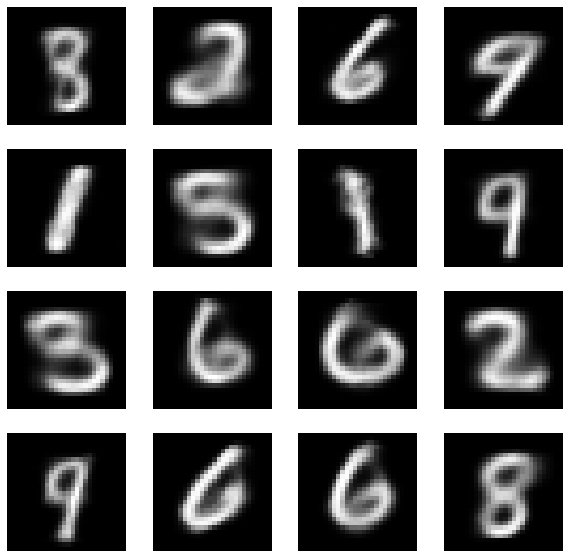

In [11]:
def generate_images(model, n_images):
    # Sample from the latent space
    random_latent_vectors = tf.random.normal(shape=(n_images, latent_dim))
    # Decode them to fake images
    generated_images = model.decoder(random_latent_vectors)
    generated_images = generated_images.numpy()

    # Calculate the number of rows needed in the subplot grid
    n_rows = int(np.ceil(n_images / 4))

    # Plot the generated images
    plt.figure(figsize=(10, 10))
    for i in range(n_images):
        plt.subplot(n_rows, 4, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Generate and display images
generate_images(vae, 16)

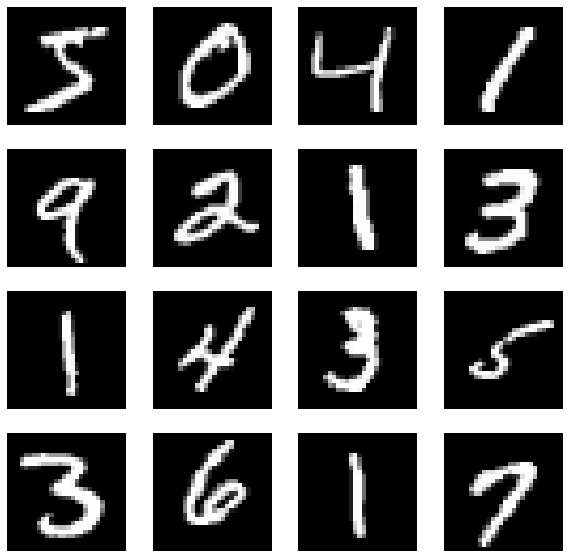

In [15]:
n_rows = int(np.ceil(16 / 4))
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(n_rows, 4, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

# __Conclusion__

In this demonstration, we have successfully implemented and trained a Variational Autoencoder (VAE) using TensorFlow to generate images based on the MNIST dataset. The process encompassed several critical steps, from importing necessary libraries to training the model, and finally, generating a manifold of digits.